## Import libraries

In [ ]:
# Tree-Based Intelligent Intrusion Detection System in Internet of Vehicles
import warnings
warnings.filterwarnings("ignore")

In [ ]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report,confusion_matrix,accuracy_score,precision_recall_fscore_support
from sklearn.metrics import f1_score
from sklearn.ensemble import RandomForestClassifier,ExtraTreesClassifier
from sklearn.tree import DecisionTreeClassifier
import xgboost as xgb
from xgboost import plot_importance

## Read the sampled CICIDS2017 dataset
The CICIDS2017 dataset is publicly available at: https://www.unb.ca/cic/datasets/ids-2017.html  
Due to the large size of this dataset, the sampled subsets of CICIDS2017 is used. The subsets are in the "data" folder.  
If you want to use this code on other datasets (e.g., CAN-intrusion dataset), just change the dataset name and follow the same steps. The models in this code are generic models that can be used in any intrusion detection/network traffic datasets.

In [ ]:
#Read dataset
#df = pd.read_csv('./data/CICIDS2017.csv')


df = pd.read_csv('/content/CICIDS2017_sample.csv')
# The results in this code is based on the original CICIDS2017 dataset. Please go to cell [10] if you work on the sampled dataset.

In [ ]:
df

,Flow Duration,Total Fwd Packets,Total Backward Packets,Total Length of Fwd Packets,Total Length of Bwd Packets,Fwd Packet Length Max,Fwd Packet Length Min,Fwd Packet Length Mean,Fwd Packet Length Std,Bwd Packet Length Max,...,min_seg_size_forward,Active Mean,Active Std,Active Max,Active Min,Idle Mean,Idle Std,Idle Max,Idle Min,Label
0,60202640,9,9,322.0,256.0,322,0,35.777778,107.333333,256.0,...,32.0,63678.2,22252.53596,103175.0,50911.0,10200000.0,34941.27201,10200000.0,10100000.0,Bot
1,57891,1,1,0.0,0.0,0,0,0.000000,0.000000,0.0,...,32.0,0.0,0.00000,0.0,0.0,0.0,0.00000,0.0,0.0,Bot
2,134812,4,3,206.0,134.0,194,0,51.500000,95.042096,128.0,...,20.0,0.0,0.00000,0.0,0.0,0.0,0.00000,0.0,0.0,Bot
3,84,1,1,6.0,6.0,6,6,6.000000,0.000000,6.0,...,20.0,0.0,0.00000,0.0,0.0,0.0,0.00000,0.0,0.0,Bot
4,127781,4,3,206.0,134.0,194,0,51.500000,95.042096,128.0,...,20.0,0.0,0.00000,0.0,0.0,0.0,0.00000,0.0,0.0,Bot
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4177,5005388,5,3,599.0,2021.0,599,0,119.800000,267.880944,2021.0,...,32.0,0.0,0.00000,0.0,0.0,0.0,0.00000,0.0,0.0,WebAttack
4178,5016759,5,5,599.0,4149.0,599,0,119.800000,267.880944,2701.0,...,32.0,0.0,0.00000,0.0,0.0,0.0,0.00000,0.0,0.0,WebAttack
4179,5009163,4,4,599.0,2021.0,599,0,149.750000,299.500000,2021.0,...,32.0,0.0,0.00000,0.0,0.0,0.0,0.00000,0.0,0.0,WebAttack
4180,73,1,1,0.0,0.0,0,0,0.000000,0.000000,0.0,...,32.0,0.0,0.00000,0.0,0.0,0.0,0.00000,0.0,0.0,WebAttack


In [ ]:
df.Label.value_counts()

WebAttack       2180
Bot             1966
Infiltration      36
Name: Label, dtype: int64

### Data sampling
Due to the space limit of GitHub files, we sample a small-sized subset for model learning using random sampling

In [ ]:
# Randomly sample instances from majority classes
df_minor = df[(df['Label']=='WebAttack')|(df['Label']=='Bot')|(df['Label']=='Infiltration')]
df_BENIGN = df[(df['Label']=='BENIGN')]
df_BENIGN = df_BENIGN.sample(n=None, frac=0.01, replace=False, weights=None, random_state=None, axis=0)
df_DoS = df[(df['Label']=='DoS')]
df_DoS = df_DoS.sample(n=None, frac=0.05, replace=False, weights=None, random_state=None, axis=0)
df_PortScan = df[(df['Label']=='PortScan')]
df_PortScan = df_PortScan.sample(n=None, frac=0.05, replace=False, weights=None, random_state=None, axis=0)
df_BruteForce = df[(df['Label']=='BruteForce')]
df_BruteForce = df_BruteForce.sample(n=None, frac=0.2, replace=False, weights=None, random_state=None, axis=0)

In [ ]:
df_s = df_BENIGN.append(df_DoS).append(df_PortScan).append(df_BruteForce).append(df_minor)

In [ ]:
df_s = df_s.sort_index()

In [ ]:
# Save the sampled dataset
df_s.to_csv('/content/CICIDS2017_sample.csv',index=0)

### Preprocessing (normalization and padding values)

In [ ]:
df = pd.read_csv('/content/CICIDS2017_sample.csv')

In [ ]:
# Min-max normalization
numeric_features = df.dtypes[df.dtypes != 'object'].index
df[numeric_features] = df[numeric_features].apply(
    lambda x: (x - x.min()) / (x.max()-x.min()))
# Fill empty values by 0
df = df.fillna(0)

### split train set and test set

In [ ]:
labelencoder = LabelEncoder()
df.iloc[:, -1] = labelencoder.fit_transform(df.iloc[:, -1])
X = df.drop(['Label'],axis=1).values
y = df.iloc[:, -1].values.reshape(-1,1)
y=np.ravel(y)
X_train, X_test, y_train, y_test = train_test_split(X,y, train_size = 0.8, test_size = 0.2, random_state = 0,stratify = y)

In [ ]:
X_train.shape

(3345, 77)

In [ ]:
pd.Series(y_train).value_counts()

2    1744
0    1572
1      29
dtype: int64

### Oversampling by SMOTE

In [ ]:
# # from imblearn.over_sampling import SMOTE
# # smote=SMOTE(n_jobs=-1,sampling_strategy={4:1500}) # Create 1500 samples for the minority class "4"


# from imblearn.over_sampling import SMOTE
# smote=SMOTE(n_jobs=-1,sampling_strategy={4:1000}) # Create 1500 samples for the minority class "4"


In [ ]:
print(np.unique(y))

[0 1 2]


In [ ]:
from imblearn.over_sampling import SMOTE
smote = SMOTE(sampling_strategy='minority')

In [ ]:
X_train, y_train = smote.fit_resample(X_train, y_train)

In [ ]:
pd.Series(y_train).value_counts()

2    1744
1    1744
0    1572
dtype: int64

## Machine learning model training

### Training four base learners: decision tree, random forest, extra trees, XGBoost

Accuracy of DT: 0.998805256869773
Precision of DT: 0.9989545997610514
Recall of DT: 0.998805256869773
F1-score of DT: 0.998844322591778
              precision    recall  f1-score   support

           0       1.00      1.00      1.00       394
           1       0.88      1.00      0.93         7
           2       1.00      1.00      1.00       436

    accuracy                           1.00       837
   macro avg       0.96      1.00      0.98       837
weighted avg       1.00      1.00      1.00       837



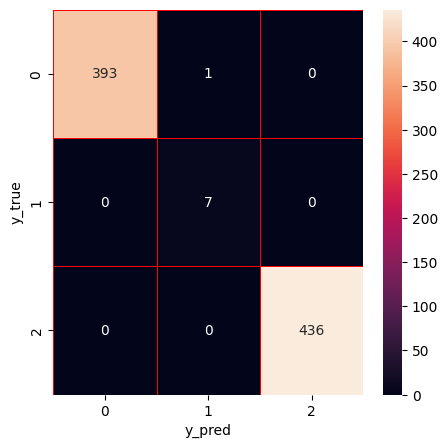

In [ ]:
# Decision tree training and prediction
dt = DecisionTreeClassifier(random_state = 0)
dt.fit(X_train,y_train)
dt_score=dt.score(X_test,y_test)
y_predict=dt.predict(X_test)
y_true=y_test
print('Accuracy of DT: '+ str(dt_score))
precision,recall,fscore,none= precision_recall_fscore_support(y_true, y_predict, average='weighted')
print('Precision of DT: '+(str(precision)))
print('Recall of DT: '+(str(recall)))
print('F1-score of DT: '+(str(fscore)))
print(classification_report(y_true,y_predict))
cm=confusion_matrix(y_true,y_predict)
f,ax=plt.subplots(figsize=(5,5))
sns.heatmap(cm,annot=True,linewidth=0.5,linecolor="red",fmt=".0f",ax=ax)
plt.xlabel("y_pred")
plt.ylabel("y_true")
plt.show()

In [ ]:
dt_train=dt.predict(X_train)
dt_test=dt.predict(X_test)

Accuracy of RF: 1.0
Precision of RF: 1.0
Recall of RF: 1.0
F1-score of RF: 1.0
              precision    recall  f1-score   support

           0       1.00      1.00      1.00       394
           1       1.00      1.00      1.00         7
           2       1.00      1.00      1.00       436

    accuracy                           1.00       837
   macro avg       1.00      1.00      1.00       837
weighted avg       1.00      1.00      1.00       837



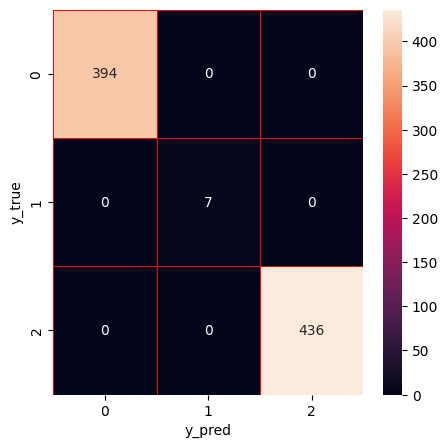

In [ ]:
# Random Forest training and prediction
rf = RandomForestClassifier(random_state = 0)
rf.fit(X_train,y_train)
rf_score=rf.score(X_test,y_test)
y_predict=rf.predict(X_test)
y_true=y_test
print('Accuracy of RF: '+ str(rf_score))
precision,recall,fscore,none= precision_recall_fscore_support(y_true, y_predict, average='weighted')
print('Precision of RF: '+(str(precision)))
print('Recall of RF: '+(str(recall)))
print('F1-score of RF: '+(str(fscore)))
print(classification_report(y_true,y_predict))
cm=confusion_matrix(y_true,y_predict)
f,ax=plt.subplots(figsize=(5,5))
sns.heatmap(cm,annot=True,linewidth=0.5,linecolor="red",fmt=".0f",ax=ax)
plt.xlabel("y_pred")
plt.ylabel("y_true")
plt.show()

In [ ]:
rf_train=rf.predict(X_train)
rf_test=rf.predict(X_test)

Accuracy of ET: 1.0
Precision of ET: 1.0
Recall of ET: 1.0
F1-score of ET: 1.0
              precision    recall  f1-score   support

           0       1.00      1.00      1.00       394
           1       1.00      1.00      1.00         7
           2       1.00      1.00      1.00       436

    accuracy                           1.00       837
   macro avg       1.00      1.00      1.00       837
weighted avg       1.00      1.00      1.00       837



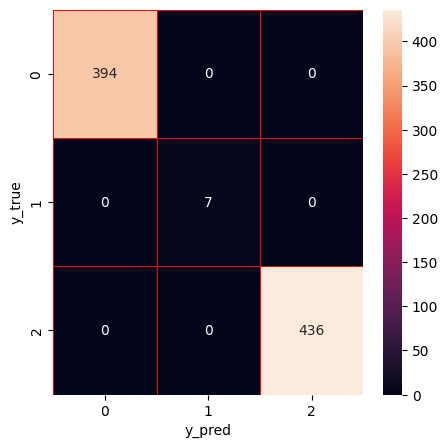

In [ ]:
# Extra trees training and prediction
et = ExtraTreesClassifier(random_state = 0)
et.fit(X_train,y_train)
et_score=et.score(X_test,y_test)
y_predict=et.predict(X_test)
y_true=y_test
print('Accuracy of ET: '+ str(et_score))
precision,recall,fscore,none= precision_recall_fscore_support(y_true, y_predict, average='weighted')
print('Precision of ET: '+(str(precision)))
print('Recall of ET: '+(str(recall)))
print('F1-score of ET: '+(str(fscore)))
print(classification_report(y_true,y_predict))
cm=confusion_matrix(y_true,y_predict)
f,ax=plt.subplots(figsize=(5,5))
sns.heatmap(cm,annot=True,linewidth=0.5,linecolor="red",fmt=".0f",ax=ax)
plt.xlabel("y_pred")
plt.ylabel("y_true")
plt.show()

In [ ]:
et_train=et.predict(X_train)
et_test=et.predict(X_test)

Accuracy of XGBoost: 0.998805256869773
Precision of XGBoost: 0.998807990835746
Recall of XGBoost: 0.998805256869773
F1-score of XGBoost: 0.9988051820951863
              precision    recall  f1-score   support

           0       1.00      1.00      1.00       394
           1       1.00      1.00      1.00         7
           2       1.00      1.00      1.00       436

    accuracy                           1.00       837
   macro avg       1.00      1.00      1.00       837
weighted avg       1.00      1.00      1.00       837



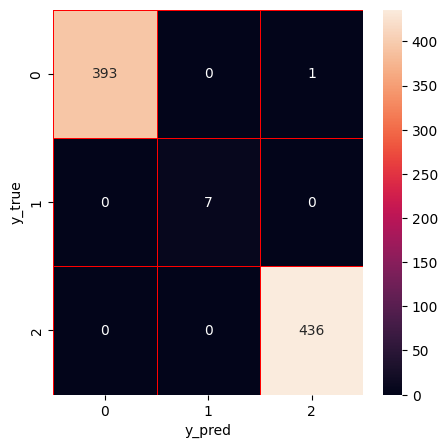

In [ ]:
# XGboost training and prediction
xg = xgb.XGBClassifier(n_estimators = 10)
xg.fit(X_train,y_train)
xg_score=xg.score(X_test,y_test)
y_predict=xg.predict(X_test)
y_true=y_test
print('Accuracy of XGBoost: '+ str(xg_score))
precision,recall,fscore,none= precision_recall_fscore_support(y_true, y_predict, average='weighted')
print('Precision of XGBoost: '+(str(precision)))
print('Recall of XGBoost: '+(str(recall)))
print('F1-score of XGBoost: '+(str(fscore)))
print(classification_report(y_true,y_predict))
cm=confusion_matrix(y_true,y_predict)
f,ax=plt.subplots(figsize=(5,5))
sns.heatmap(cm,annot=True,linewidth=0.5,linecolor="red",fmt=".0f",ax=ax)
plt.xlabel("y_pred")
plt.ylabel("y_true")
plt.show()

In [ ]:
xg_train=xg.predict(X_train)
xg_test=xg.predict(X_test)

### Stacking model construction (ensemble for 4 base learners)

In [ ]:
# Use the outputs of 4 base models to construct a new ensemble model
base_predictions_train = pd.DataFrame( {
    'DecisionTree': dt_train.ravel(),
        'RandomForest': rf_train.ravel(),
     'ExtraTrees': et_train.ravel(),
     'XgBoost': xg_train.ravel(),
    })
base_predictions_train.head(5)

,DecisionTree,RandomForest,ExtraTrees,XgBoost
0,2,2,2,2
1,0,0,0,0
2,2,2,2,2
3,2,2,2,2
4,0,0,0,0


In [ ]:
dt_train=dt_train.reshape(-1, 1)
et_train=et_train.reshape(-1, 1)
rf_train=rf_train.reshape(-1, 1)
xg_train=xg_train.reshape(-1, 1)
dt_test=dt_test.reshape(-1, 1)
et_test=et_test.reshape(-1, 1)
rf_test=rf_test.reshape(-1, 1)
xg_test=xg_test.reshape(-1, 1)

In [ ]:
x_train = np.concatenate(( dt_train, et_train, rf_train, xg_train), axis=1)
x_test = np.concatenate(( dt_test, et_test, rf_test, xg_test), axis=1)

In [ ]:
stk = xgb.XGBClassifier().fit(x_train, y_train)

Accuracy of Stacking: 0.998805256869773
Precision of Stacking: 0.9989545997610514
Recall of Stacking: 0.998805256869773
F1-score of Stacking: 0.998844322591778
              precision    recall  f1-score   support

           0       1.00      1.00      1.00       394
           1       0.88      1.00      0.93         7
           2       1.00      1.00      1.00       436

    accuracy                           1.00       837
   macro avg       0.96      1.00      0.98       837
weighted avg       1.00      1.00      1.00       837



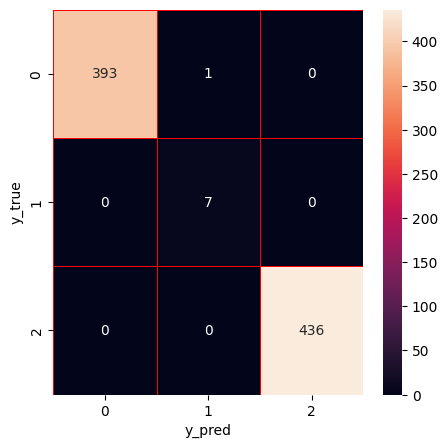

In [ ]:
y_predict=stk.predict(x_test)
y_true=y_test
stk_score=accuracy_score(y_true,y_predict)
print('Accuracy of Stacking: '+ str(stk_score))
precision,recall,fscore,none= precision_recall_fscore_support(y_true, y_predict, average='weighted')
print('Precision of Stacking: '+(str(precision)))
print('Recall of Stacking: '+(str(recall)))
print('F1-score of Stacking: '+(str(fscore)))
print(classification_report(y_true,y_predict))
cm=confusion_matrix(y_true,y_predict)
f,ax=plt.subplots(figsize=(5,5))
sns.heatmap(cm,annot=True,linewidth=0.5,linecolor="red",fmt=".0f",ax=ax)
plt.xlabel("y_pred")
plt.ylabel("y_true")
plt.show()

## Feature Selection

### Feature importance

In [ ]:
# Save the feature importance lists generated by four tree-based algorithms
dt_feature = dt.feature_importances_
rf_feature = rf.feature_importances_
et_feature = et.feature_importances_
xgb_feature = xg.feature_importances_

In [ ]:
# calculate the average importance value of each feature
avg_feature = (dt_feature + rf_feature + et_feature + xgb_feature)/4

In [ ]:
feature=(df.drop(['Label'],axis=1)).columns.values
print ("Features sorted by their score:")
print (sorted(zip(map(lambda x: round(x, 4), avg_feature), feature), reverse=True))

Features sorted by their score:
[(0.2895, 'min_seg_size_forward'), (0.2305, 'Flow Duration'), (0.0478, 'Init_Win_bytes_forward'), (0.035, 'Bwd Packet Length Max'), (0.0299, 'Init_Win_bytes_backward'), (0.0193, 'Bwd IAT Total'), (0.0182, 'Packet Length Mean'), (0.0182, 'Fwd IAT Total'), (0.0157, 'Flow IAT Max'), (0.0148, 'Fwd IAT Max'), (0.014, 'Average Packet Size'), (0.0124, 'Fwd IAT Std'), (0.0121, 'Min Packet Length'), (0.012, 'Max Packet Length'), (0.0119, 'Idle Mean'), (0.0114, 'Avg Bwd Segment Size'), (0.0111, 'Bwd Packet Length Mean'), (0.01, 'Idle Max'), (0.009, 'Bwd IAT Max'), (0.0087, 'Active Mean'), (0.0086, 'Fwd Packet Length Min'), (0.0076, 'Fwd Header Length.1'), (0.0074, 'Bwd Packet Length Min'), (0.0072, 'ACK Flag Count'), (0.0068, 'Down/Up Ratio'), (0.0062, 'Avg Fwd Segment Size'), (0.0059, 'Total Length of Bwd Packets'), (0.0059, 'Idle Min'), (0.0058, 'Flow IAT Mean'), (0.0056, 'Subflow Fwd Packets'), (0.0051, 'Subflow Bwd Bytes'), (0.0051, 'SYN Flag Count'), (0.0048,

In [ ]:
f_list = sorted(zip(map(lambda x: round(x, 4), avg_feature), feature), reverse=True)

In [ ]:
len(f_list)

77

In [ ]:
# Select the important features from top-importance to bottom-importance until the accumulated importance reaches 0.9 (out of 1)
Sum = 0
fs = []
for i in range(0, len(f_list)):
    Sum = Sum + f_list[i][0]
    fs.append(f_list[i][1])
    if Sum>=0.9:
        break

In [ ]:
X_fs = df[fs].values

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X_fs,y, train_size = 0.8, test_size = 0.2, random_state = 0,stratify = y)

In [ ]:
X_train.shape

(3345, 31)

In [ ]:
pd.Series(y_train).value_counts()

2    1744
0    1572
1      29
dtype: int64

### Oversampling by SMOTE

In [ ]:
# from imblearn.over_sampling import SMOTE
# smote=SMOTE(n_jobs=-1,sampling_strategy={4:1500})

from imblearn.over_sampling import SMOTE
smote = SMOTE(sampling_strategy='minority')

In [ ]:
X_train, y_train = smote.fit_resample(X_train, y_train)

In [ ]:
pd.Series(y_train).value_counts()

2    1744
1    1744
0    1572
dtype: int64

## Machine learning model training after feature selection

Accuracy of DT: 0.998805256869773
Precision of DT: 0.9989545997610514
Recall of DT: 0.998805256869773
F1-score of DT: 0.998844322591778
              precision    recall  f1-score   support

           0       1.00      1.00      1.00       394
           1       0.88      1.00      0.93         7
           2       1.00      1.00      1.00       436

    accuracy                           1.00       837
   macro avg       0.96      1.00      0.98       837
weighted avg       1.00      1.00      1.00       837



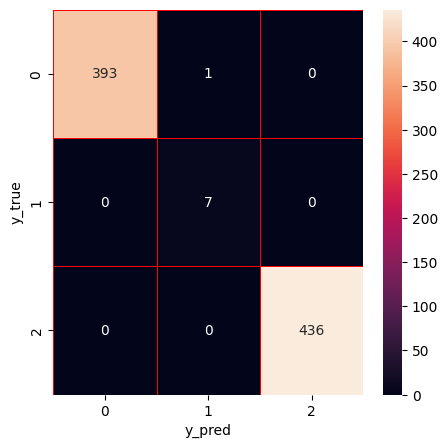

In [ ]:
dt = DecisionTreeClassifier(random_state = 0)
dt.fit(X_train,y_train)
dt_score=dt.score(X_test,y_test)
y_predict=dt.predict(X_test)
y_true=y_test
print('Accuracy of DT: '+ str(dt_score))
precision,recall,fscore,none= precision_recall_fscore_support(y_true, y_predict, average='weighted')
print('Precision of DT: '+(str(precision)))
print('Recall of DT: '+(str(recall)))
print('F1-score of DT: '+(str(fscore)))
print(classification_report(y_true,y_predict))
cm=confusion_matrix(y_true,y_predict)
f,ax=plt.subplots(figsize=(5,5))
sns.heatmap(cm,annot=True,linewidth=0.5,linecolor="red",fmt=".0f",ax=ax)
plt.xlabel("y_pred")
plt.ylabel("y_true")
plt.show()

In [ ]:
dt_train=dt.predict(X_train)
dt_test=dt.predict(X_test)

Accuracy of RF: 0.998805256869773
Precision of RF: 0.9989545997610514
Recall of RF: 0.998805256869773
F1-score of RF: 0.998844322591778
              precision    recall  f1-score   support

           0       1.00      1.00      1.00       394
           1       0.88      1.00      0.93         7
           2       1.00      1.00      1.00       436

    accuracy                           1.00       837
   macro avg       0.96      1.00      0.98       837
weighted avg       1.00      1.00      1.00       837



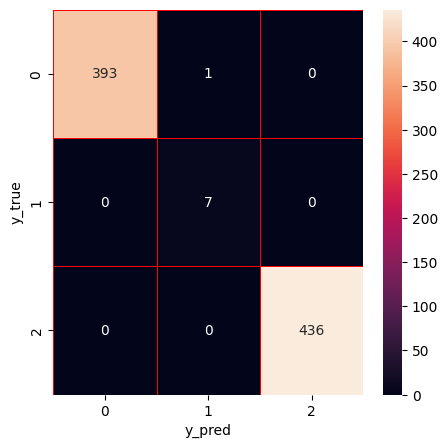

In [ ]:
rf = RandomForestClassifier(random_state = 0)
rf.fit(X_train,y_train) # modelin veri üzerinde öğrenmesi fit fonksiyonuyla yapılıyor
rf_score=rf.score(X_test,y_test)
y_predict=rf.predict(X_test)
y_true=y_test
print('Accuracy of RF: '+ str(rf_score))
precision,recall,fscore,none= precision_recall_fscore_support(y_true, y_predict, average='weighted')
print('Precision of RF: '+(str(precision)))
print('Recall of RF: '+(str(recall)))
print('F1-score of RF: '+(str(fscore)))
print(classification_report(y_true,y_predict))
cm=confusion_matrix(y_true,y_predict)
f,ax=plt.subplots(figsize=(5,5))
sns.heatmap(cm,annot=True,linewidth=0.5,linecolor="red",fmt=".0f",ax=ax)
plt.xlabel("y_pred")
plt.ylabel("y_true")
plt.show()

In [ ]:
rf_train=rf.predict(X_train)
rf_test=rf.predict(X_test)

Accuracy of ET: 1.0
Precision of ET: 1.0
Recall of ET: 1.0
F1-score of ET: 1.0
              precision    recall  f1-score   support

           0       1.00      1.00      1.00       394
           1       1.00      1.00      1.00         7
           2       1.00      1.00      1.00       436

    accuracy                           1.00       837
   macro avg       1.00      1.00      1.00       837
weighted avg       1.00      1.00      1.00       837



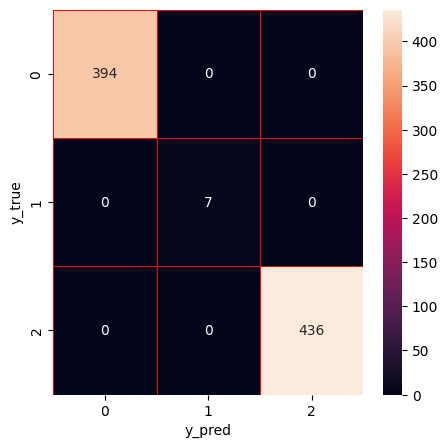

In [ ]:
et = ExtraTreesClassifier(random_state = 0)
et.fit(X_train,y_train)
et_score=et.score(X_test,y_test)
y_predict=et.predict(X_test)
y_true=y_test
print('Accuracy of ET: '+ str(et_score))
precision,recall,fscore,none= precision_recall_fscore_support(y_true, y_predict, average='weighted')
print('Precision of ET: '+(str(precision)))
print('Recall of ET: '+(str(recall)))
print('F1-score of ET: '+(str(fscore)))
print(classification_report(y_true,y_predict))
cm=confusion_matrix(y_true,y_predict)
f,ax=plt.subplots(figsize=(5,5))
sns.heatmap(cm,annot=True,linewidth=0.5,linecolor="red",fmt=".0f",ax=ax)
plt.xlabel("y_pred")
plt.ylabel("y_true")
plt.show()

In [ ]:
et_train=et.predict(X_train)
et_test=et.predict(X_test)

Accuracy of XGBoost: 0.998805256869773
Precision of XGBoost: 0.998807990835746
Recall of XGBoost: 0.998805256869773
F1-score of XGBoost: 0.9988051820951863
              precision    recall  f1-score   support

           0       1.00      1.00      1.00       394
           1       1.00      1.00      1.00         7
           2       1.00      1.00      1.00       436

    accuracy                           1.00       837
   macro avg       1.00      1.00      1.00       837
weighted avg       1.00      1.00      1.00       837



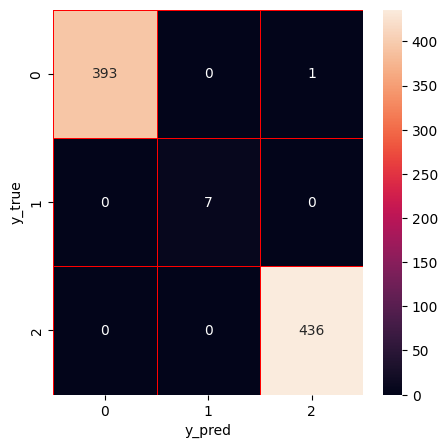

In [ ]:
xg = xgb.XGBClassifier(n_estimators = 10)
xg.fit(X_train,y_train)
xg_score=xg.score(X_test,y_test)
y_predict=xg.predict(X_test)
y_true=y_test
print('Accuracy of XGBoost: '+ str(xg_score))
precision,recall,fscore,none= precision_recall_fscore_support(y_true, y_predict, average='weighted')
print('Precision of XGBoost: '+(str(precision)))
print('Recall of XGBoost: '+(str(recall)))
print('F1-score of XGBoost: '+(str(fscore)))
print(classification_report(y_true,y_predict))
cm=confusion_matrix(y_true,y_predict)
f,ax=plt.subplots(figsize=(5,5))
sns.heatmap(cm,annot=True,linewidth=0.5,linecolor="red",fmt=".0f",ax=ax)
plt.xlabel("y_pred")
plt.ylabel("y_true")
plt.show()

In [ ]:
xg_train=xg.predict(X_train)
xg_test=xg.predict(X_test)

### Stacking model construction

In [ ]:
base_predictions_train = pd.DataFrame( {
    'DecisionTree': dt_train.ravel(),
        'RandomForest': rf_train.ravel(),
     'ExtraTrees': et_train.ravel(),
     'XgBoost': xg_train.ravel(),
    })
base_predictions_train.head(5)

,DecisionTree,RandomForest,ExtraTrees,XgBoost
0,2,2,2,2
1,0,0,0,0
2,2,2,2,2
3,2,2,2,2
4,0,0,0,0


In [ ]:
with open('dt_model.pkl', 'wb') as f:
    pickle.dump(dt_test, f)

# Load model
with open('dt_model.pkl', 'rb') as f:
   dt_model= pickle.load(f)


with open('et_model.pkl', 'wb') as f:
    pickle.dump(et_test, f)

# Load model
with open('et_model.pkl', 'rb') as f:
   et_model = pickle.load(f)


with open('rf_model.pkl', 'wb') as f:
    pickle.dump(rf_test, f)

# Load model
with open('rf_model.pkl', 'rb') as f:
   rf_model= pickle.load(f)


with open('xg_model.pkl', 'wb') as f:
    pickle.dump(xg_test, f)

# Load model
with open('xg_model.pkl', 'rb') as f:
   xg_model = pickle.load(f)




In [ ]:
dt_train=dt_train.reshape(-1, 1)
et_train=et_train.reshape(-1, 1)
rf_train=rf_train.reshape(-1, 1)
xg_train=xg_train.reshape(-1, 1)
dt_test=dt_model.reshape(-1, 1)
et_test=et_model.reshape(-1, 1)
rf_test=rf_model.reshape(-1, 1)
xg_test=xg_model.reshape(-1, 1)

In [ ]:
x_train = np.concatenate(( dt_train, et_train, rf_train, xg_train), axis=1)
x_test = np.concatenate(( dt_test, et_test, rf_test, xg_test), axis=1)

Accuracy of Stacking: 0.998805256869773
Precision of Stacking: 0.9989545997610514
Recall of Stacking: 0.998805256869773
F1-score of Stacking: 0.998844322591778
              precision    recall  f1-score   support

           0       1.00      1.00      1.00       394
           1       0.88      1.00      0.93         7
           2       1.00      1.00      1.00       436

    accuracy                           1.00       837
   macro avg       0.96      1.00      0.98       837
weighted avg       1.00      1.00      1.00       837



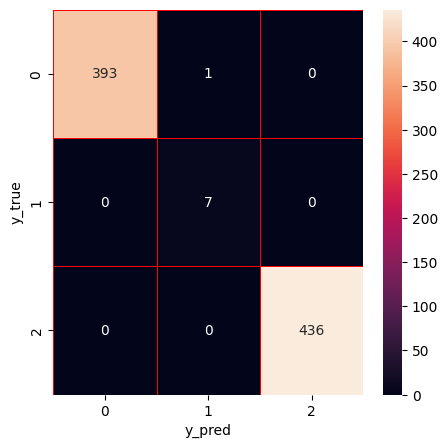

In [ ]:
stk = xgb.XGBClassifier().fit(x_train, y_train)
y_predict=stk.predict(x_test)
y_true=y_test
stk_score=accuracy_score(y_true,y_predict)
print('Accuracy of Stacking: '+ str(stk_score))
precision,recall,fscore,none= precision_recall_fscore_support(y_true, y_predict, average='weighted')
print('Precision of Stacking: '+(str(precision)))
print('Recall of Stacking: '+(str(recall)))
print('F1-score of Stacking: '+(str(fscore)))
print(classification_report(y_true,y_predict))
cm=confusion_matrix(y_true,y_predict)
f,ax=plt.subplots(figsize=(5,5))
sns.heatmap(cm,annot=True,linewidth=0.5,linecolor="red",fmt=".0f",ax=ax)
plt.xlabel("y_pred")
plt.ylabel("y_true")
plt.show()

In [ ]:
import pickle

# # Train model
# stk = xgb.XGBClassifier().fit(x_train, y_train)

# Evaluate model
y_predict = stk.predict(x_test)
# Calculate accuracy, precision, recall, etc.

# Save model
with open('stk_model.pkl', 'wb') as f:
    pickle.dump(stk, f)

#Load model
with open('stk_model.pkl', 'rb') as f:
   stk_loaded = pickle.load(f)

# Make predictions with loaded model
y_pred_loaded = stk_loaded.predict(x_test)

print(y_pred_loaded)

[2 2 0 2 2 2 0 1 2 2 2 2 2 0 2 0 0 2 2 2 1 0 0 0 0 2 2 0 2 2 2 0 0 2 0 2 0
 0 2 0 0 0 0 0 2 2 0 2 2 0 2 2 2 2 2 2 0 2 0 2 0 0 0 2 2 2 0 0 0 0 2 2 2 2
 0 0 0 0 0 0 0 2 2 0 2 0 0 0 0 0 2 0 2 0 0 2 0 2 2 2 2 0 0 0 0 0 0 2 2 2 0
 0 0 2 2 2 0 2 1 0 0 0 0 0 2 0 0 2 2 2 2 1 2 0 0 2 0 0 2 2 0 0 2 0 0 2 0 2
 2 2 2 2 2 2 0 2 0 0 0 0 2 2 2 0 0 2 2 0 2 0 0 0 1 0 2 2 2 0 2 2 0 0 2 2 2
 2 2 0 2 2 2 0 2 2 0 0 0 2 2 0 2 0 2 2 0 0 0 2 0 0 2 0 2 0 2 2 0 2 0 0 2 2
 2 2 2 2 2 2 0 0 2 0 0 0 2 0 2 2 0 0 0 0 2 0 2 2 2 2 0 2 0 2 2 0 2 0 2 0 2
 0 2 2 2 2 0 0 2 2 2 0 0 0 2 0 0 0 0 2 2 0 0 0 2 0 0 2 2 2 2 2 0 2 0 0 0 2
 0 2 0 2 0 2 2 0 2 2 0 0 0 2 2 2 2 2 2 1 0 2 2 2 2 0 2 2 0 0 0 0 2 2 2 2 0
 2 2 0 2 0 2 2 0 0 2 0 2 0 2 2 2 2 0 0 2 2 0 0 2 2 0 2 0 0 0 2 2 0 2 2 2 0
 2 2 0 0 0 2 0 0 2 0 2 2 2 0 0 2 2 0 0 2 0 2 0 2 0 2 2 2 0 0 0 2 0 0 0 0 2
 0 0 2 2 2 0 2 2 2 0 0 2 2 0 2 2 0 0 2 2 2 0 2 0 2 2 2 2 0 2 0 0 2 2 0 2 2
 0 0 2 2 2 2 0 0 0 2 0 2 2 0 2 0 2 0 2 2 2 0 2 0 2 2 0 0 2 2 0 0 2 2 0 0 2
 2 2 2 2 2 2 2 2 0 2 0 0 

In [ ]:
# Calculate and print evaluation metrics - most common class = class of detected attack type
class_output = np.bincount(y_pred_loaded).argmax()

#return class output
 return class_output

SyntaxError: ignored